In [ ]:
# imports
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split

OUTDIR = Path("reports/lab4"); (OUTDIR / "figures").mkdir(parents=True, exist_ok=True)
SEED = 42


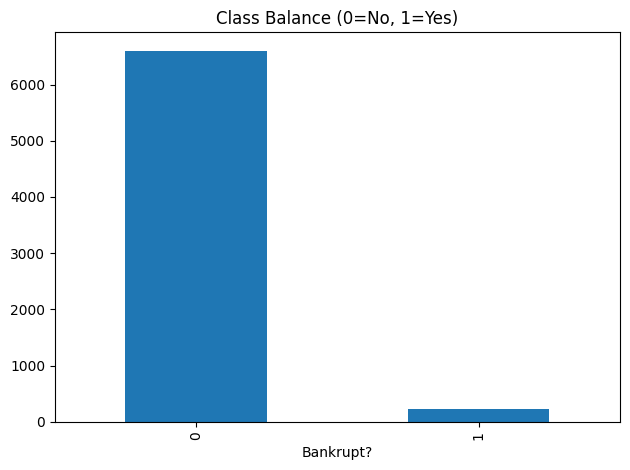

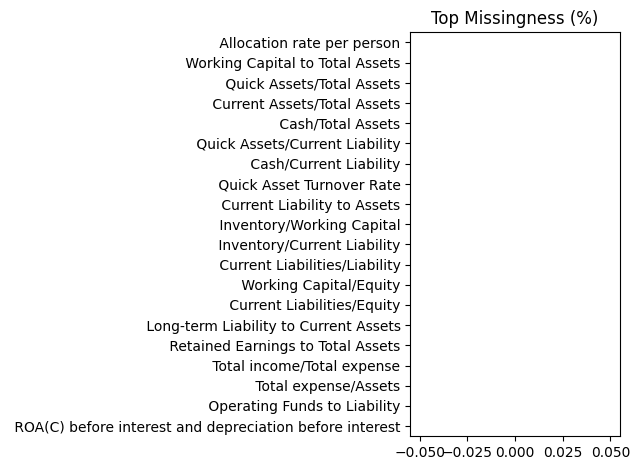

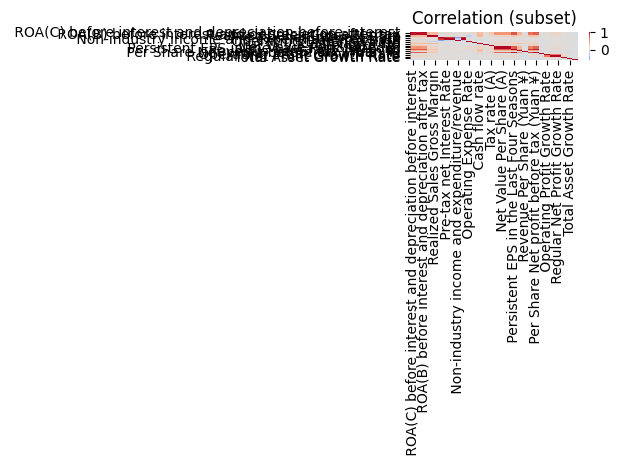

In [11]:
# load
df = pd.read_csv("data/raw/company_bankruptcy.csv")
target = "Bankrupt?"
X = df.drop(columns=[target]).apply(pd.to_numeric, errors="coerce")
y = df[target].astype(int)

# class imbalance figure
ax = y.value_counts().sort_index().plot(kind="bar", title="Class Balance (0=No, 1=Yes)")
plt.tight_layout(); plt.savefig(OUTDIR / "figures/class_balance.png", dpi=150); plt.show()

# missingness and small corr heatmap
(X.isna().mean().sort_values(ascending=False).head(20)*100).plot(kind="barh", title="Top Missingness (%)")
plt.tight_layout(); plt.savefig(OUTDIR / "figures/missingness.png", dpi=150); plt.show()

subcols = X.columns[:min(30, X.shape[1])]
sns.heatmap(X[subcols].corr(numeric_only=True), cmap="coolwarm", center=0)
plt.title("Correlation (subset)"); plt.tight_layout()
plt.savefig(OUTDIR / "figures/corr_subset.png", dpi=150); plt.show()


In [12]:
# stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)
X_train.shape, X_test.shape, y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)


((5455, 95),
 (1364, 95),
 Bankrupt?
 0    0.967736
 1    0.032264
 Name: proportion, dtype: float64,
 Bankrupt?
 0    0.967742
 1    0.032258
 Name: proportion, dtype: float64)

In [ ]:
# PSI utils
from typing import Tuple

def _psi_one(train_col: pd.Series, test_col: pd.Series, bins: int = 10) -> float:
    """
    Compute PSI for a single numeric column using train-quantile binning.
    PSI thresholds (rule of thumb): <0.1 stable, 0.1–0.25 watch, >0.25 action.
    """
    tr = train_col.replace([np.inf, -np.inf], np.nan).dropna()
    te = test_col.replace([np.inf, -np.inf], np.nan).dropna()
    if tr.empty or te.empty:
        return np.nan
    # quantile edges from TRAIN to avoid peeking
    qs = np.linspace(0, 1, bins + 1)
    edges = np.unique(np.quantile(tr, qs))
    if len(edges) < 2:
        return 0.0  # constant feature
    tr_bins = pd.cut(tr, edges, include_lowest=True).value_counts(normalize=True).sort_index()
    te_bins = pd.cut(te, edges, include_lowest=True).value_counts(normalize=True).sort_index()
    idx = tr_bins.index.union(te_bins.index)
    tr_bins = tr_bins.reindex(idx, fill_value=0)
    te_bins = te_bins.reindex(idx, fill_value=0)
    eps = 1e-6
    return float(((tr_bins - te_bins) * np.log((tr_bins + eps) / (te_bins + eps))).sum())

def compute_psi_table(Xtr: pd.DataFrame, Xte: pd.DataFrame, bins: int = 10) -> pd.DataFrame:
    num_cols = Xtr.select_dtypes(include=[np.number]).columns
    rows = [{"feature": c, "psi": _psi_one(Xtr[c], Xte[c], bins=bins)} for c in num_cols]
    return pd.DataFrame(rows).sort_values("psi", ascending=False).reset_index(drop=True)


In [ ]:
# compute & save PSI
psi_df = compute_psi_table(X_train, X_test, bins=10)
psi_df.to_csv(OUTDIR / "psi_table.csv", index=False)
psi_df.head(10)


,feature,psi
0,Operating profit per person,0.020918
1,Working Capital to Total Assets,0.019572
2,Cash flow rate,0.019172
3,Non-industry income and expenditure/revenue,0.019090
4,Quick Assets/Total Assets,0.017491
5,Working Capital/Equity,0.016958
6,Current Liability to Current Assets,0.016693
7,Current Ratio,0.016662
8,Per Share Net profit before tax (Yuan ¥),0.016466
9,Inventory/Working Capital,0.015213


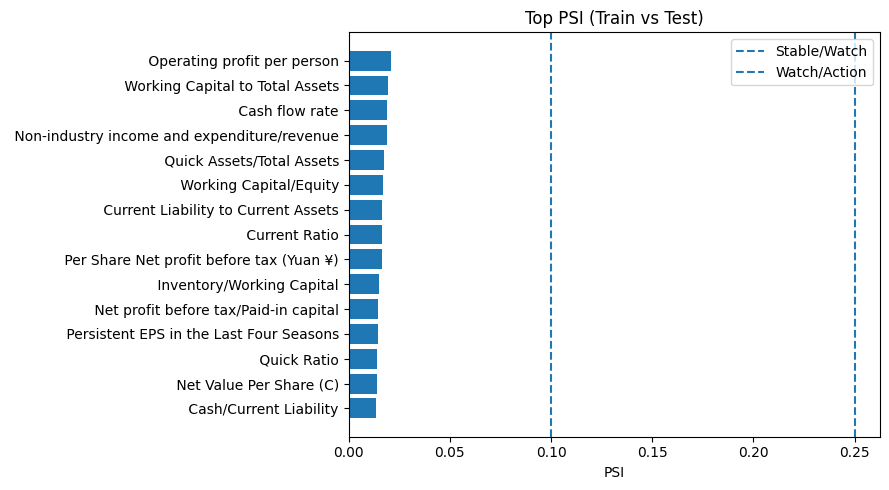

In [ ]:
# bar chart of top PSI features with guide lines
top = psi_df.head(15).sort_values("psi")
plt.figure(figsize=(9, 5))
plt.barh(top["feature"], top["psi"])
plt.axvline(0.10, ls="--", label="Stable/Watch")
plt.axvline(0.25, ls="--", label="Watch/Action")
plt.title("Top PSI (Train vs Test)")
plt.xlabel("PSI"); plt.legend(); plt.tight_layout()
plt.savefig(OUTDIR / "figures/psi_top.png", dpi=150); plt.show()


In [9]:
# Class balance
pos, neg = int((y==1).sum()), int((y==0).sum())
rate = pos / (pos + neg)

# PSI summary
max_psi = float(psi_df["psi"].max())
top3 = psi_df["feature"].head(3).tolist()
n_action = int((psi_df["psi"] >= 0.25).sum())
n_watch  = int(((psi_df["psi"] >= 0.10) & (psi_df["psi"] < 0.25)).sum())
n_stable = int((psi_df["psi"] < 0.10).sum())

print(f"MAX_PSI = {max_psi:.4f}")
print(f"Top 3 PSI features = {top3}")
print(f"Counts: ≥0.25 (action) = {n_action}, 0.10–0.25 (watch) = {n_watch}, <0.10 (stable) = {n_stable}")
print(f"Class balance: positives={pos}, negatives={neg}, rate={rate:.2%}")


MAX_PSI = 0.0209
Top 3 PSI features = [' Operating profit per person', ' Working Capital to Total Assets', ' Cash flow rate']
Counts: ≥0.25 (action) = 0, 0.10–0.25 (watch) = 0, <0.10 (stable) = 95
Class balance: positives=220, negatives=6599, rate=3.23%
